In [1]:
import nbimporter
from data_loader import load_data
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


c:\Users\Nouran\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = (224, 224)  # ResNet50 default input size
BATCH_SIZE = 64
EPOCHS = 50

In [3]:
train_gen, val_gen, test_gen, _ = load_data(
    train_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/train",
    valid_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/valid",
    test_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/test",
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)


Found 4793 images belonging to 30 classes.
Found 150 images belonging to 30 classes.
Found 150 images belonging to 30 classes.


In [4]:
# Number of classes (from your loaded generators)
NUM_CLASSES = len(train_gen.class_indices)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 30


In [5]:
# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [6]:
for layer in base_model.layers[:-100]:  # Freeze fewer layers
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


In [7]:
# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,654,238 (94.05 MB)

 Trainable params: 23,217,438 (88.57 MB)

 Non-trainable params: 1,436,800 (5.48 MB)

In [10]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [11]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)


C:\Users\Nouran\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.0850 - loss: 4.0957 - val_accuracy: 0.0533 - val_loss: 3.4655 - learning_rate: 1.0000e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.2502 - loss: 2.7992 - val_accuracy: 0.3000 - val_loss: 2.6525 - learning_rate: 1.0000e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 364s 5s/step - accuracy: 0.3880 - loss: 2.3031 - val_accuracy: 0.5533 - val_loss: 1.6586 - learning_rate: 1.0000e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 528s 7s/step - accuracy: 0.4692 - loss: 1.9304 - val_accuracy: 0.7200 - val_loss: 0.9669 - learning_rate: 1.0000e-04
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 640s 9s/step - accuracy: 0.5510 - loss: 1.5718 - val_accuracy: 0.7800 - val_loss: 0.7954 - learning_rate: 1.0000e-04
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 603s 8s/step - accuracy: 0.6023 - loss: 1.4254 - val_accuracy: 0.8133 - val_loss: 0.7569 - learning_rate: 1.0000e-04
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 626s 8s/step - accuracy: 0.6496 

In [12]:
# Evaluate
loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9421 - loss: 0.2279
Test Accuracy: 94.67%


In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Step 1: Unfreeze the top layers of the base model ===
# Unfreeze only the last 50 layers for fine-tuning (not all!)
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# === Step 2: Compile the model with a slightly higher learning rate ===
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Step 3: Callbacks to prevent overfitting and plateauing ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-7)

# === Step 4: Fine-tune the model ===
fine_tune_epochs = 30  # or more, depending on patience
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    callbacks=[early_stop, reduce_lr]
)

# === Step 5: Final evaluation ===
loss_fine, accuracy_fine = model.evaluate(test_gen)
print(f" Final Test Accuracy after fine-tuning: {accuracy_fine * 100:.2f}%")


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.8880 - loss: 0.3850 - val_accuracy: 0.9400 - val_loss: 0.2122 - learning_rate: 5.0000e-06
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.8937 - loss: 0.3606 - val_accuracy: 0.9467 - val_loss: 0.2181 - learning_rate: 5.0000e-06
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 293s 4s/step - accuracy: 0.8847 - loss: 0.3618 - val_accuracy: 0.9467 - val_loss: 0.2159 - learning_rate: 5.0000e-06
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.9072 - loss: 0.3265 - val_accuracy: 0.9467 - val_loss: 0.2167 - learning_rate: 1.5000e-06
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 309s 4s/step - accuracy: 0.8936 - loss: 0.3410 - val_accuracy: 0.9467 - val_loss: 0.2184 - learning_rate: 1.5000e-06
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - accuracy: 0.8998 - loss: 0.3373 - val_accuracy: 0.9467 - val_loss: 0.2180 - learning_rate: 4.5000e-07
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9479 - loss: 0.2180


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted class: concertina


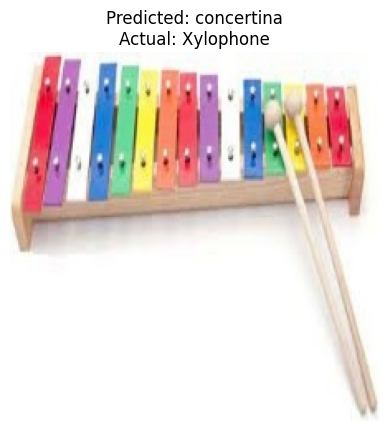

In [18]:
import random

import matplotlib.pyplot as plt

# Get a random image and its label from the test generator
rand_idx = random.randint(0, len(test_gen.filenames) - 1)
img_path = test_gen.filepaths[rand_idx]
actual_label_idx = test_gen.classes[rand_idx]
# Reverse mapping from index to class name
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
actual_label = idx_to_class[actual_label_idx]

# Predict using the test_single_image function
predicted_class = test_single_image(model, img_path, train_gen.class_indices, img_size=IMG_SIZE)

# Display the image with predicted and actual label
img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class}\nActual: {actual_label}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


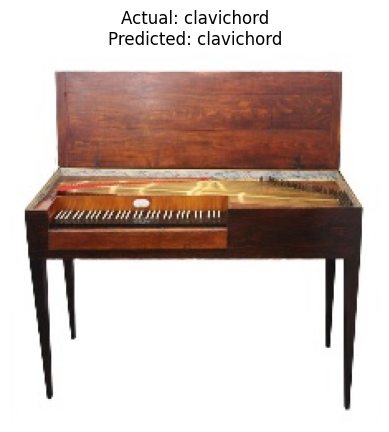

In [26]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def test_random_image(model, test_gen, img_size=(299, 299)):
    # Pick a random index
    idx = random.randint(0, test_gen.samples - 1)
    # Get image path and label
    img_path = test_gen.filepaths[idx]
    true_label_idx = test_gen.labels[idx]
    class_indices = test_gen.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}
    true_label = idx_to_class[true_label_idx]

    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_exp)

    # Predict
    preds = model.predict(img_preprocessed)
    pred_idx = np.argmax(preds, axis=1)[0]
    pred_label = idx_to_class[pred_idx]

    # Show image and labels
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}")
    plt.show()

# Test random image
test_random_image(model, test_gen, img_size=IMG_SIZE)

In [28]:
# Save the model
model.save('fine_tuned_resnet50_model.h5')


In [29]:
# load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('musical_instruments_model_Mobile_Net.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


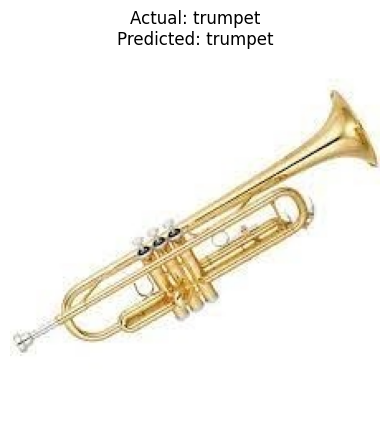

In [32]:
# Test the prediction of the loaded model
test_random_image(loaded_model, test_gen, img_size=IMG_SIZE)
